In [3]:
#import all necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [4]:
#reading in the data into a DataFrame and dropping the Serial Number column

df = pd.read_excel("Malaria_data.xlsx").drop(["s/n"], axis=1)
df.head(10)

,age,test,result,drug,dosage,resistance
0,29,mRDT,NEG,Not ACT,0,0
1,21,mRDT,NEG,Not ACT,0,0
2,42,mRDT,POS,ACT,4,0
3,21,mRDT,NEG,Not ACT,0,0
4,60,mRDT,NEG,Not ACT,0,0
5,63,mRDT,POS,ACT,4,1
6,22,mRDT,NEG,Not ACT,0,0
7,18,mRDT,NEG,Not ACT,0,0
8,24,mRDT,NEG,Not ACT,0,0
9,19,mRDT,NEG,Not ACT,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   age         500 non-null    int64 
 1   test        500 non-null    object
 2   result      500 non-null    object
 3   drug        500 non-null    object
 4   dosage      500 non-null    int64 
 5   resistance  500 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 23.6+ KB


In [41]:
df.count()

age           486
test          486
result        486
drug          486
dosage        486
resistance    486
dtype: int64

In [6]:
df.describe()

,age,dosage,resistance
count,500.000000,500.000000,500.000000
mean,30.918000,2.110000,0.316000
std,22.724967,1.811204,0.465379
min,1.000000,0.000000,0.000000
25%,13.750000,0.000000,0.000000
50%,25.000000,3.000000,0.000000
75%,43.000000,4.000000,1.000000
max,95.000000,4.000000,1.000000


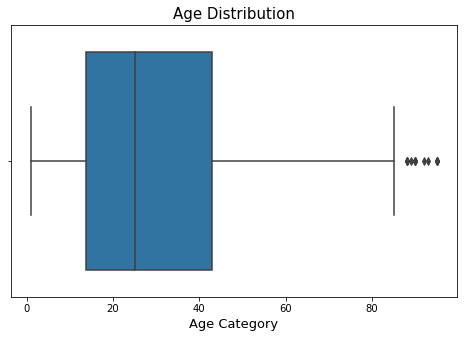

In [7]:
# There seem to be outliers around

plt.figure(figsize=(8, 5))
sns.boxplot(df["age"])

plt.xlabel("Age Category", fontsize=13)
plt.title("Age Distribution", fontsize=15);

In [8]:
# Create a filter to trim off the outlier ages, cap max age to 85years and reassign the trimmed data to 'df'

df = (df[df["age"] < 86])
df.head()

,age,test,result,drug,dosage,resistance
0,29,mRDT,NEG,Not ACT,0,0
1,21,mRDT,NEG,Not ACT,0,0
2,42,mRDT,POS,ACT,4,0
3,21,mRDT,NEG,Not ACT,0,0
4,60,mRDT,NEG,Not ACT,0,0


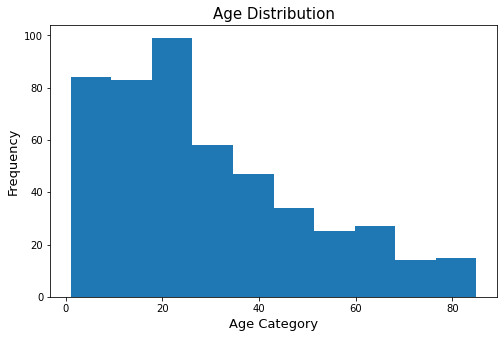

In [9]:
# comment 

plt.figure(figsize=(8, 5))

df["age"].plot(kind="hist", bins=10)
plt.xlabel("Age Category", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.title("Age Distribution", fontsize=15);

In [10]:
df.resistance.value_counts()

0    333
1    153
Name: resistance, dtype: int64

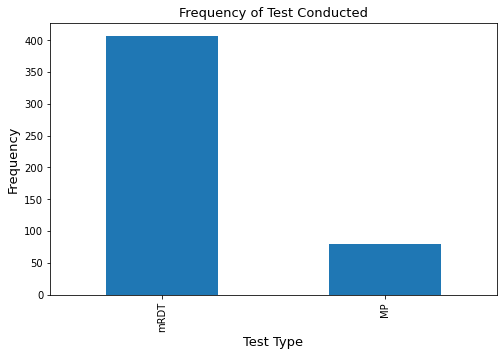

In [11]:
# 

plt.figure(figsize=(8, 5))

df.test.value_counts().plot(kind="bar")
plt.xlabel("Test Type", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.title("Frequency of Test Conducted", fontsize=13);

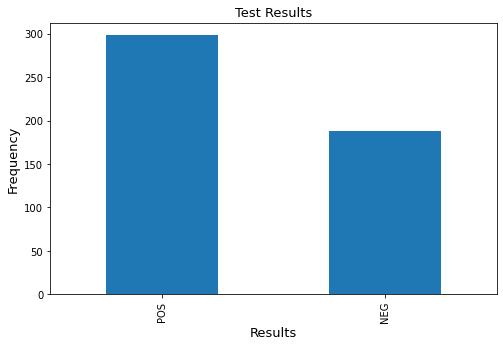

In [12]:
# 

plt.figure(figsize=(8, 5))

df.result.value_counts().plot(kind="bar")
plt.xlabel("Results", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.title("Test Results", fontsize=13);

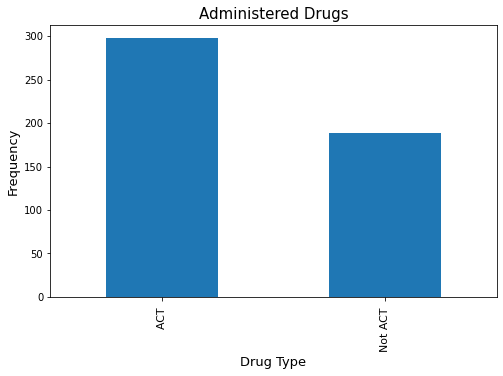

In [13]:
# 

plt.figure(figsize=(8, 5))

df.drug.value_counts().plot(kind="bar", )
plt.xlabel("Drug Type", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.xticks(fontsize=11)
plt.title("Administered Drugs", fontsize=15);

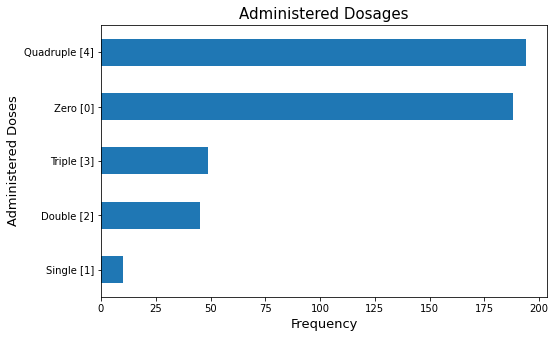

In [14]:
# 

plt.figure(figsize=(8, 5))

df.dosage.value_counts().sort_values().plot(kind="barh")
plt.xlabel("Frequency", fontsize=13)
plt.ylabel("Administered Doses", fontsize=13)
plt.title("Administered Dosages", fontsize=15)
plt.yticks([4, 3, 2, 1, 0], ["Quadruple [4]", "Zero [0]", "Triple [3]", "Double [2]", "Single [1]"]);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


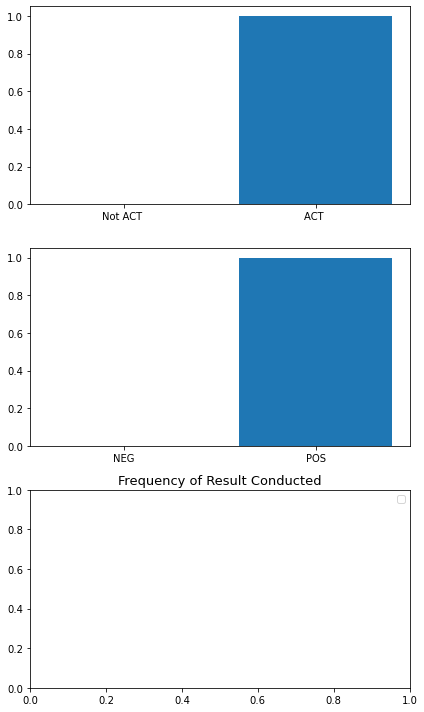

In [15]:
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(6, 10))

axs[0, 0].bar(df["drug"], df["resistance"], label="Drug/Resistance")
plt.legend()

axs[0, 1].plot(df["result"], df["resistance"], label="Drug/Resistance", kind="bar")
plt.legend()
plt.title("Frequency of Result Conducted", fontsize=13)



plt.tight_layout()

plt.show()

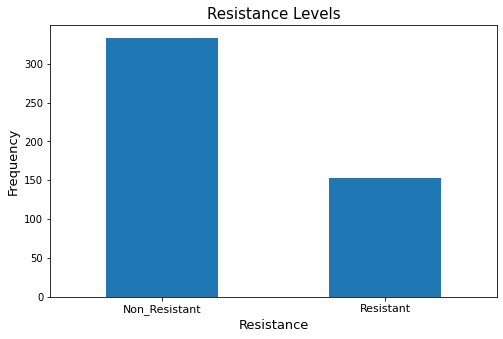

In [16]:
# 

plt.figure(figsize=(8, 5))

df.resistance.value_counts().plot(kind="bar")
plt.xlabel("Resistance", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.xticks([0, 1], ["Non_Resistant", "Resistant"], rotation=360, fontsize=11)
plt.title("Resistance Levels", fontsize=15);

In [17]:
# 

resistant = []
non_resistant = []

for i in df.resistance:
    if i == 1:
        resistant.asappend("Resistant")
    else:
        non_resistant.append("Non_Resistant")

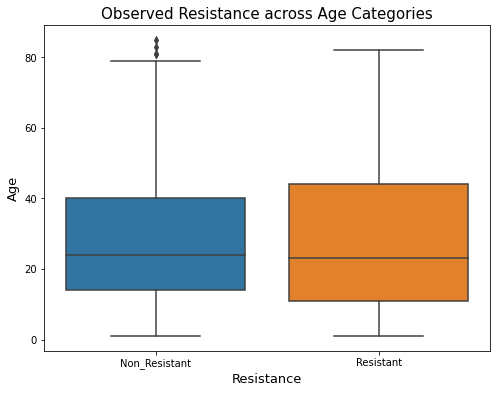

In [18]:
#

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x=label, y="age");

plt.xlabel("Resistance" , fontsize=13)
plt.ylabel("Age", fontsize=13)
plt.title("Observed Resistance across Age Categories", fontsize=15);

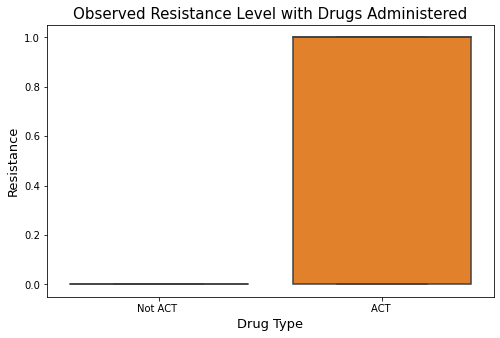

In [19]:
#

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="drug", y="resistance")

plt.xlabel("Drug Type" , fontsize=13)
plt.ylabel("Resistance", fontsize=13)
plt.title("Observed Resistance Level with Drugs Administered", fontsize=15);


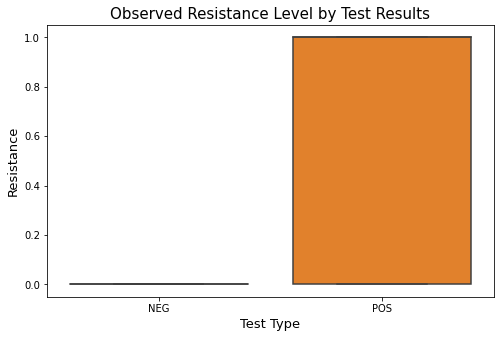

In [20]:
# 

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="result", y="resistance")

plt.xlabel("Test Type" , fontsize=13)
plt.ylabel("Resistance", fontsize=13)
plt.title("Observed Resistance Level by Test Results", fontsize=15);

In [21]:
df.corr()

,age,dosage,resistance
age,1.000000,0.183712,0.002504
dosage,0.183712,1.000000,0.478747
resistance,0.002504,0.478747,1.000000


In [22]:
#instantiating the LabelEncoder class to encode all categorical variables
lb = LabelEncoder()

# Specifying categorical variables
df1 = df[["test", "result", "drug"]]

# Creating a For loop Function to Label-Encode all categorical variables
def encode(data):
    for i in df1.columns:
        df[i] = lb.fit_transform(df[i])
    
    return df

In [23]:
encode(df)

,age,test,result,drug,dosage,resistance
0,29,1,0,1,0,0
1,21,1,0,1,0,0
2,42,1,1,0,4,0
3,21,1,0,1,0,0
4,60,1,0,1,0,0
...,...,...,...,...,...,...
495,2,0,1,0,1,0
496,2,0,1,0,2,1
497,62,0,1,0,4,1
498,22,1,1,0,4,1


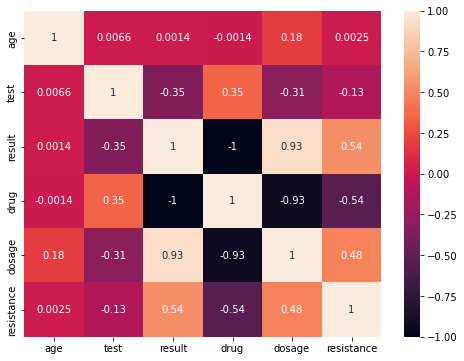

In [24]:
#conducting correlation among all variables
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True);

In [25]:
#defining the Predictors (X) and Response (y) variables
X1 = df.drop(["resistance"], axis=1)
y = df["resistance"]

In [26]:
std = StandardScaler()
X = std.fit_transform(X1)
X

array([[-0.00871394,  0.44057144, -1.25901008,  1.25901008, -1.1668165 ],
       [-0.398137  ,  0.44057144, -1.25901008,  1.25901008, -1.1668165 ],
       [ 0.62409853,  0.44057144,  0.79427482, -0.79427482,  1.05047702],
       ...,
       [ 1.59765618, -2.26977945,  0.79427482, -0.79427482,  1.05047702],
       [-0.34945912,  0.44057144,  0.79427482, -0.79427482,  1.05047702],
       [ 1.79236771,  0.44057144,  0.79427482, -0.79427482,  1.05047702]])

In [27]:
# Splitting the target and features into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=11)

In [28]:
# building the Baseline model

y_train.value_counts(normalize=True).max()

0.6726804123711341

The above baseline model score is what we'd look forward to beating

In [29]:
# Instantiating imported models

logreg = LogisticRegression(random_state=11)
tree = DecisionTreeClassifier(random_state=11)
bag = BaggingClassifier(base_estimator=tree, n_estimators=13, n_jobs=-1, random_state=11)

In [30]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=11)

In [31]:
# Building a function to fit instantiated models above and 
# return their respective classifications and confusion matrix on the test set

def compute(model):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    conf_m = classification_report(y_test, y_pred)
    output = print("Model test Accuracy:", test_acc, '\n\n', conf_m)

    return output


In [32]:
compute(logreg)

Model test Accuracy: 0.673469387755102 

               precision    recall  f1-score   support

           0       0.87      0.65      0.75        72
           1       0.43      0.73      0.54        26

    accuracy                           0.67        98
   macro avg       0.65      0.69      0.64        98
weighted avg       0.75      0.67      0.69        98



In [33]:
compute(tree)

Model test Accuracy: 0.7142857142857143 

               precision    recall  f1-score   support

           0       0.82      0.78      0.80        72
           1       0.47      0.54      0.50        26

    accuracy                           0.71        98
   macro avg       0.65      0.66      0.65        98
weighted avg       0.73      0.71      0.72        98



In [34]:
compute(bag)

Model test Accuracy: 0.7040816326530612 

               precision    recall  f1-score   support

           0       0.83      0.75      0.79        72
           1       0.45      0.58      0.51        26

    accuracy                           0.70        98
   macro avg       0.64      0.66      0.65        98
weighted avg       0.73      0.70      0.71        98



In [35]:
importances = tree.feature_importances_

In [36]:
tree.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(random_state=11)>

In [37]:
feat_n = X1.columns.str.capitalize()

In [38]:
merge = pd.Series(importances, feat_n).sort_values()
merge

Drug      0.000000
Test      0.026167
Dosage    0.045210
Result    0.453890
Age       0.474734
dtype: float64

Text(0.5, 1.0, 'Feature Importamces')

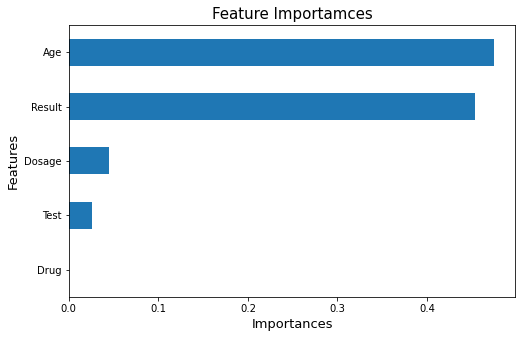

In [39]:
plt.figure(figsize=(8, 5))

merge.plot(kind="barh")
plt.ylabel("Features", fontsize=13)
plt.xlabel("Importances",  fontsize=13)
plt.title("Feature Importamces",  fontsize=15)

In [40]:
plt.figure(figsize=(12, 8))

plot_tree(tree, filled=True, feature_names=importances, class_names=y.name)
plt.show()

NameError: name 'plot_tree' is not defined

<Figure size 864x576 with 0 Axes>